In [1]:
# Setup Notebook to load Django code
# From project root, run: jupyter-lab",

import os
import sys
import io
from pathlib import Path

django_project_dir = Path('..')
sys.path.insert(0, str(django_project_dir)),
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "traffic_stops.settings.dev")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import django
django.setup()

In [46]:
from django.db.models.functions import TruncYear
from django.db.models import Count, Sum

import pandas as pd

from nc.models import Agency, Stop, Person

In [29]:
%matplotlib inline

In [3]:
dpd = Agency.objects.get(name="Durham Police Department")
dpd

2021-05-20 10:52:05,363 caching              DEBUG    query_key: bcb2c74e50a23b908695023feec39f40
2021-05-20 10:52:05,365 caching              DEBUG    query_flush: :flush:1f58578cd6bb32e0f77fd4b2de85a74c


<Agency: Durham Police Department>

# 1. allowing analyses to be limited male/female drivers (already in dataset)

## Durham PD - Traffic Stops by Count by Gender

In [6]:
qs = Person.objects.filter(
    stop__date__year__gt=2001,
    stop__agency_id=dpd.pk,
    type="D",
).order_by("stop__date")
df = pd.DataFrame(qs.values("stop__date", "gender"))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338903 entries, 0 to 338902
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   stop__date  338903 non-null  datetime64[ns, UTC]
 1   gender      338903 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 5.2+ MB


In [106]:
df.gender.value_counts()

M    212301
F    126602
Name: gender, dtype: int64

In [114]:
df2 = df.groupby([pd.Grouper(key='stop__date', freq='6M'), 'gender'])['gender'].count()
df2 = df2.unstack(level=1).fillna(0)

<AxesSubplot:title={'center':'Durham PD Stops By Gender'}, xlabel='Month', ylabel='Stops'>

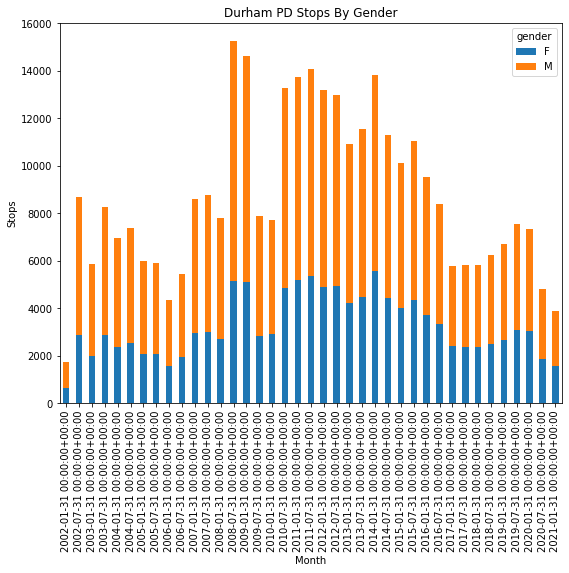

In [115]:
df2.plot(
    kind="bar",
    stacked=True,
    xlabel="Month",
    ylabel="Stops",
    title="Durham PD Stops By Gender",
    figsize=(9, 7)
)

### TRAFFIC STOPS BY PERCENTAGE 

In [158]:
df3 = pd.DataFrame(
    qs.annotate(
        date_year=TruncYear('stop__date')
    ).values(
        "date_year",
        "gender",
        "race",
        "ethnicity",
    ).annotate(
        stops=Count("stop_id"),
    ).order_by("date_year", "race", "gender")
)
df3["year"] = pd.DatetimeIndex(df3.date_year).year
df3 = df3.drop("date_year", axis=1)
df3

,gender,race,ethnicity,stops,year
0,F,A,N,88,2002
1,M,A,N,163,2002
2,F,B,H,21,2002
3,F,B,N,2953,2002
4,M,B,H,43,2002
...,...,...,...,...,...
338,M,U,N,24,2020
339,F,W,H,358,2020
340,F,W,N,989,2020
341,M,W,H,775,2020


In [159]:
stops_race = df3.groupby(['year', "race"]).agg({'stops': 'sum'})
stops_race

stops
year race       
2002 A       251
     B      8192
     I        28
     U       640
     W      5966
...          ...
2020 A       193
     B      6213
     I        38
     U        58
     W      3588

[95 rows x 1 columns]

In [160]:
stops_year = df3.groupby(['year']).agg({'stops': 'sum'})
stops_year

,stops
year,
2002,15077
2003,15366
2004,13298
2005,10675
2006,12974
2007,18348
2008,27384
2009,14997
2010,27558


In [161]:
df4 = stop_race.div(stops_year, level='year') * 100
df4

stops
year race           
2002 A      1.664787
     B     54.334417
     I      0.185713
     U      4.244876
     W     39.570206
...              ...
2020 A      1.912785
     B     61.575818
     I      0.376611
     U      0.574827
     W     35.559960

[95 rows x 1 columns]

In [162]:
df4 = df4.unstack().reset_index().rename_axis((None,None), axis=1)
df4.columns = ['_'.join(col).strip('_') for col in df4.columns]
df4 = df4.set_index("year")
df4

,stops_A,stops_B,stops_I,stops_U,stops_W
year,,,,,
2002,1.664787,54.334417,0.185713,4.244876,39.570206
2003,1.340622,54.392815,0.071587,2.922036,41.272940
2004,1.639344,50.970071,0.127839,3.218529,44.044217
2005,1.526932,53.067916,0.084309,3.344262,41.976581
2006,1.371975,55.534145,0.316017,1.780484,40.997379
2007,1.422498,56.529322,0.408764,0.654022,40.985394
2008,1.402279,60.020450,0.387087,0.591586,37.598598
2009,1.426952,59.351870,0.400080,0.413416,38.407682
2010,1.618405,58.033965,0.468104,0.344727,39.534799


<AxesSubplot:title={'center':'TRAFFIC STOPS BY PERCENTAGE'}, xlabel='Year', ylabel='Percentage of Stops'>

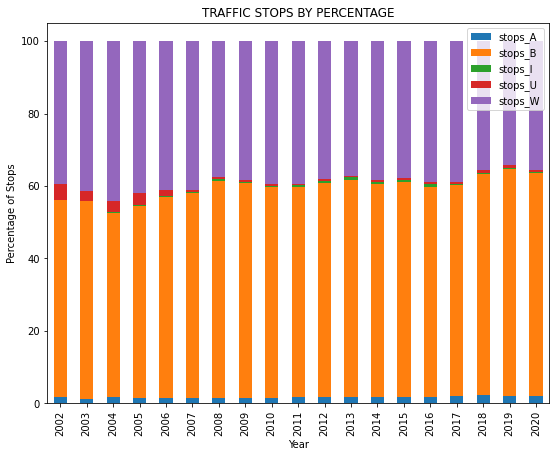

In [150]:
df4.plot(
    kind="bar",
    stacked=True,
    xlabel="Year",
    ylabel="Percentage of Stops",
    title="TRAFFIC STOPS BY PERCENTAGE",
    figsize=(9, 7)
)

In [168]:
male = df3[df3.gender == "M"]
male

,gender,race,ethnicity,stops,year
1,M,A,N,163,2002
4,M,B,H,43,2002
5,M,B,N,5175,2002
8,M,I,H,4,2002
9,M,I,N,9,2002
...,...,...,...,...,...
334,M,I,N,26,2020
337,M,U,H,20,2020
338,M,U,N,24,2020
341,M,W,H,775,2020


In [175]:
stops_race = male.groupby(['year', "race"]).agg({'stops': 'sum'})
stops_year = male.groupby(['year']).agg({'stops': 'sum'})
df5 = stops_race.div(stops_year, level='year') * 100

df5 = df5.unstack().reset_index().rename_axis((None,None), axis=1)
df5.columns = ['_'.join(col).strip('_') for col in df5.columns]
df5 = df5.set_index("year")
df5

,stops_A,stops_B,stops_I,stops_U,stops_W
year,,,,,
2002,1.636546,52.389558,0.130522,4.849398,40.993976
2003,1.368514,52.367825,0.068918,3.692035,42.502707
2004,1.578767,48.907448,0.160165,3.946917,45.406704
2005,1.605903,50.506366,0.086806,4.267940,43.532986
2006,1.463066,52.694183,0.344951,2.081599,43.416201
2007,1.552511,54.229971,0.539643,0.805313,42.872561
2008,1.390202,58.054830,0.472669,0.711783,39.370517
2009,1.295445,57.689093,0.449227,0.553698,40.012537
2010,1.577123,56.493356,0.519931,0.375505,41.034084


<AxesSubplot:title={'center':'MALE TRAFFIC STOPS BY PERCENTAGE'}, xlabel='Year', ylabel='Percentage of Stops'>

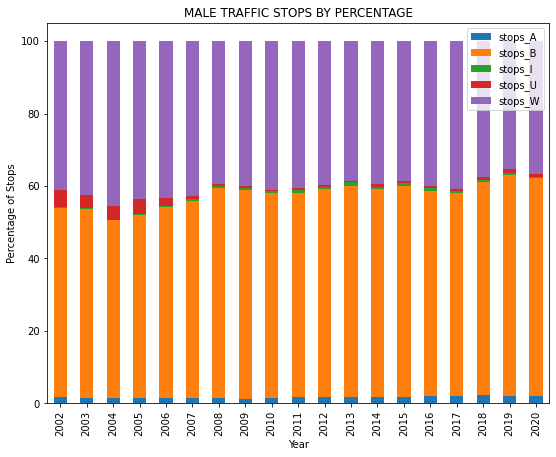

In [176]:
df5.plot(
    kind="bar",
    stacked=True,
    xlabel="Year",
    ylabel="Percentage of Stops",
    title="MALE TRAFFIC STOPS BY PERCENTAGE",
    figsize=(9, 7)
)

stops
year race           
2002 A      1.636546
     B     52.389558
     I      0.130522
     U      4.849398
     W     40.993976
...              ...
2020 A      2.034121
     B     60.055774
     I      0.426509
     U      0.721785
     W     36.761811

[95 rows x 1 columns]

# 2. adding information on whether searches led to arrest generally and as it relates to contraband hits (already in dataset)

In [10]:
df3 = pd.DataFrame(qs.values("stop__driver_arrest"))

In [17]:
df3.stop__driver_arrest.value_counts()

False    331251
True       7652
Name: stop__driver_arrest, dtype: int64

# 3. adding in some tooltips to explain certain terms on the site